# Dataset Generation for Ball-and-Stick Neuron

This notebook demonstrates how to generate a comprehensive dataset using a Ball-and-Stick neuron model. The dataset will be used to train neural network models that can approximate the behavior of biophysically detailed neuron simulations.

## Overview

We will:
1. Set up the neuron model with biophysical parameters
2. Generate training, validation, and test datasets
3. Visualize sample simulations
4. Analyze dataset statistics
5. Apply quality filters to ensure good data


## Imports

Import necessary libraries for neuron simulation, data handling, and visualization.


In [1]:
# Setup paths - since this notebook is in the notebooks/ subdirectory,
# we need to ensure we can access the compiled MOD files and save models correctly
import os
import sys

# Get the directory containing this notebook
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()

# Get the project root directory (parent of notebooks/)
project_root = os.path.dirname(notebook_dir) if 'notebooks' in notebook_dir else notebook_dir

# Change to project root so NEURON can find the compiled mechanisms
os.chdir(project_root)
print(f"Working directory set to: {os.getcwd()}")

import time
import glob
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from neuron_model_ball_and_stick import BallAndStickNeuron
from inspect_and_prune_neuron_dataset import collect_dataset_statistics, plot_dataset_statistics
from inspect_and_prune_neuron_dataset import filter_dataset_folder
import config

Working directory set to: /home/davidbeniaguev/Desktop/code/tutorial_NEURON_pytorch


## Helper Functions

We define several helper functions:
- **`get_start_index_from_folder`**: Finds the highest existing simulation index to append new data
- **`generate_bs_dataset`**: Main function to generate multiple neuron simulations with varied input patterns
- **`load_and_display_sample`**: Loads a saved simulation and creates visualizations
- **`simulate_and_display_sample`**: Runs a new simulation and displays results
- **`display_simulated_sample`**: Creates comprehensive multi-panel plots showing inputs, dendritic voltages, soma voltage, spikes, and firing rates


In [2]:
def get_start_index_from_folder(folder):
    """Get the maximal index (sim_[num].npy) of all filenames in folder"""
    all_filenames = glob.glob(os.path.join(folder, '*.npy'))
    all_indices = [int(os.path.basename(filename).split('sim_')[-1].split('.')[0]) for filename in all_filenames]
    return max(all_indices) + 1 if all_indices else 0

def generate_bs_dataset(bs_neuron, output_folder, num_simulations=32, sim_duration_ms=2048,
                        exc_max_magnitude_factor_range=[2.0, 6.0],
                        inh_max_magnitude_factor_range=[2.0, 6.0],
                        exc_sparsity_level_range=[0.995, 0.999],
                        inh_sparsity_level_range=[0.995, 0.999],
                        print_curr_sim_params=False):
    """Generate a dataset of Ball-and-Stick neuron simulations with weighted spike inputs"""

    # Create the output folders
    inputs_folder = os.path.join(output_folder, 'inputs')
    output_spikes_folder = os.path.join(output_folder, 'output_spikes')
    output_soma_v_folder = os.path.join(output_folder, 'output_soma_v')
    output_near_spikes_folder = os.path.join(output_folder, 'output_near_spikes')
    output_inst_rate_folder = os.path.join(output_folder, 'output_inst_rate')
    intermidiate_branch_v_folder = os.path.join(output_folder, 'intermidiate_branch_v')
    
    os.makedirs(inputs_folder, exist_ok=True)
    os.makedirs(output_spikes_folder, exist_ok=True)
    os.makedirs(output_soma_v_folder, exist_ok=True)
    os.makedirs(output_near_spikes_folder, exist_ok=True)
    os.makedirs(output_inst_rate_folder, exist_ok=True)
    os.makedirs(intermidiate_branch_v_folder, exist_ok=True)

    # Get start index for appending to existing dataset
    start_index = get_start_index_from_folder(output_spikes_folder)
    
    # Get number of segments from BS neuron
    num_segments = bs_neuron.num_segments
    
    # Generate data
    for sim_ind in range(start_index, start_index + num_simulations):
        # Sample magnitude and sparsity factors for this simulation
        exc_max_magnitude_factor = np.random.uniform(exc_max_magnitude_factor_range[0], exc_max_magnitude_factor_range[1])
        exc_sparsity_level = np.random.uniform(exc_sparsity_level_range[0], exc_sparsity_level_range[1])
        inh_max_magnitude_factor = np.random.uniform(inh_max_magnitude_factor_range[0], inh_max_magnitude_factor_range[1])
        inh_sparsity_level = np.random.uniform(inh_sparsity_level_range[0], inh_sparsity_level_range[1])
        
        # Generate weighted spikes directly
        X_exc = np.random.rand(num_segments, sim_duration_ms) * exc_max_magnitude_factor
        X_exc[np.random.rand(num_segments, sim_duration_ms) < exc_sparsity_level] = 0.0
        
        X_inh = np.random.rand(num_segments, sim_duration_ms) * inh_max_magnitude_factor
        X_inh[np.random.rand(num_segments, sim_duration_ms) < inh_sparsity_level] = 0.0
        
        # Convert to float16 for storage efficiency
        X_exc = X_exc.astype(np.float16)
        X_inh = X_inh.astype(np.float16)

        # with probability 0.4, select K random time intervals and set inputs of randomly selected segments to multiply by a random factor
        if np.random.rand() < 0.4:
            num_intervals = np.random.randint(6, 24)
            for _ in range(num_intervals):
                interval_duration_ms = np.random.randint(16, 256)
                selected_exc_segments = np.random.choice(num_segments, size=np.random.randint(1, num_segments), replace=False)
                selected_inh_segments = np.random.choice(num_segments, size=np.random.randint(1, num_segments), replace=False)

                # randomly select a start index for the interval
                mult_factor = np.random.choice([0.0,0.3,0.5,2,3,4,5], p=[0.4, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
                start_ind = np.random.randint(0, sim_duration_ms - interval_duration_ms)
                end_ind = start_ind + interval_duration_ms
                X_exc[selected_exc_segments, start_ind:end_ind] = mult_factor * X_exc[selected_exc_segments, start_ind:end_ind]
                X_inh[selected_inh_segments, start_ind:end_ind] = mult_factor * X_inh[selected_inh_segments, start_ind:end_ind]

        # Simulate Ball-and-Stick neuron
        simulation_output_dict = bs_neuron.simulate(X_exc, X_inh, return_hr_soma=False)

        branch_voltages = simulation_output_dict['branch_voltages']
        y_soma = simulation_output_dict['y_soma']
        y_spike = simulation_output_dict['y_spike']
        y_near_spike = simulation_output_dict['y_near_spike']
        y_inst_rate = simulation_output_dict['y_inst_rate']

        # Save data
        X_inputs = np.stack([X_exc, X_inh], axis=-1)
        sample_filename = f'sim_{sim_ind:07d}.npy'
        
        np.save(os.path.join(inputs_folder, sample_filename), X_inputs)
        np.save(os.path.join(output_spikes_folder, sample_filename), y_spike)
        np.save(os.path.join(output_soma_v_folder, sample_filename), y_soma)
        np.save(os.path.join(output_near_spikes_folder, sample_filename), y_near_spike)
        np.save(os.path.join(output_inst_rate_folder, sample_filename), y_inst_rate)
        np.save(os.path.join(intermidiate_branch_v_folder, sample_filename), branch_voltages)

        if (sim_ind - start_index + 1) % 100 == 0 and print_curr_sim_params:
            print(f'Generated {sim_ind + 1 - start_index}/{num_simulations} simulations')
            print(f'X_inputs shape: {X_inputs.shape}, dtype: {X_inputs.dtype}')
            print(f'y_spike shape: {y_spike.shape}, dtype: {y_spike.dtype}')
            print(f'y_soma shape: {y_soma.shape}, dtype: {y_soma.dtype}')
            print(f'y_near_spike shape: {y_near_spike.shape}, dtype: {y_near_spike.dtype}')
            print(f'y_inst_rate shape: {y_inst_rate.shape}, dtype: {y_inst_rate.dtype}')
            print(f'branch_voltages shape: {branch_voltages.shape}, dtype: {branch_voltages.dtype}')

    num_samples_after_generation = len(glob.glob(os.path.join(output_spikes_folder, '*.npy')))
    output_folder_name = os.path.basename(output_folder)
    print(f'Generated {num_simulations} simulations in "{output_folder_name}". Total num simulations: {num_samples_after_generation}')

def load_and_display_sample(sample_filename, data_folder, bs_neuron, print_info=False):
    """Load and display a sample from the dataset."""
    
    # Load all data for the sample
    X_inputs = np.load(os.path.join(data_folder, 'inputs', sample_filename))
    y_spike = np.load(os.path.join(data_folder, 'output_spikes', sample_filename))
    y_soma = np.load(os.path.join(data_folder, 'output_soma_v', sample_filename))
    y_near_spike = np.load(os.path.join(data_folder, 'output_near_spikes', sample_filename))
    y_inst_rate = np.load(os.path.join(data_folder, 'output_inst_rate', sample_filename))
    branch_voltage = np.load(os.path.join(data_folder, 'intermidiate_branch_v', sample_filename))

    if print_info:
        print('----------------------------------------------------------------------')
        print(f'Data folder & sample name:')
        print(f'{os.path.basename(os.path.dirname(data_folder))}/{os.path.basename(data_folder)}/{sample_filename}')
        print('----------------------------------------------------------------------')
        print('Shapes and dtypes of the data:')
        print('----------------------------')
        print(f'X_inputs shape: {X_inputs.shape}, dtype: {X_inputs.dtype}')
        print(f'y_spike shape: {y_spike.shape}, dtype: {y_spike.dtype}')
        print(f'y_soma shape: {y_soma.shape}, dtype: {y_soma.dtype}')
        print(f'y_near_spike shape: {y_near_spike.shape}, dtype: {y_near_spike.dtype}')
        print(f'y_inst_rate shape: {y_inst_rate.shape}, dtype: {y_inst_rate.dtype}')
        print(f'branch_voltage shape: {branch_voltage.shape}, dtype: {branch_voltage.dtype}')
        print('----------------------------------------------------------------------')

    X_exc, X_inh = X_inputs[..., 0], X_inputs[..., 1]
    
    # display the sample
    fig = display_simulated_sample(X_exc, X_inh, y_spike, y_soma, y_near_spike, y_inst_rate, 
                                   branch_voltage, bs_neuron, title_prefix=sample_filename, 
                                   print_info=print_info)
    
    return fig

def simulate_and_display_sample(bs_neuron, X_exc, X_inh, title_prefix="", print_info=True):
    """Simulate Ball-and-Stick neuron on inputs and create comprehensive visualization plots."""

    sample_X_exc = X_exc.astype(np.float16)
    sample_X_inh = X_inh.astype(np.float16)
    
    if print_info:
        print('----------------------------------------------------------------------')
        print(f'Sample information:')
        print('-------------------')
        print(f'sample_X_exc.shape: {sample_X_exc.shape}, dtype: {sample_X_exc.dtype}')
        print(f'sample_X_inh.shape: {sample_X_inh.shape}, dtype: {sample_X_inh.dtype}')
        print('----------------------------------------------------------------------')
    
    # Simulate Ball-and-Stick neuron on the sample
    simulation_output_dict = bs_neuron.simulate(sample_X_exc, sample_X_inh, return_hr_soma=False)
    
    # Extract simulation results
    branch_voltage = simulation_output_dict['branch_voltages']
    y_soma = simulation_output_dict['y_soma']
    y_spike = simulation_output_dict['y_spike']
    y_near_spike = simulation_output_dict['y_near_spike']
    y_inst_rate = simulation_output_dict['y_inst_rate']
    
    # display the sample
    fig = display_simulated_sample(sample_X_exc, sample_X_inh, y_spike, y_soma, y_near_spike, 
                                   y_inst_rate, branch_voltage, bs_neuron, title_prefix=title_prefix, 
                                   print_info=print_info)
    
    return fig

def display_simulated_sample(X_exc, X_inh, y_spike, y_soma, y_near_spike, y_inst_rate, 
                             branch_voltage, bs_neuron, title_prefix="", print_info=True):
    """
    Create comprehensive visualization plots for neuron simulation data.
    Creates a detailed multi-panel figure showing input signals, dendritic voltages,
    soma voltage with spikes, near-spike activity, and instantaneous firing rate.
    """
    
    # Get simulation duration
    sim_duration_ms = len(y_soma)
    
    # Calculate statistics for display
    excitation_mean = np.mean(X_exc.astype(np.float32))
    excitation_std = np.std(X_exc.astype(np.float32))
    inhibition_mean = np.mean(X_inh.astype(np.float32))
    inhibition_std = np.std(X_inh.astype(np.float32))
    branch_voltage_mean = np.mean(branch_voltage.astype(np.float32))
    branch_voltage_std = np.std(branch_voltage.astype(np.float32))
    soma_mean_voltage = np.mean(y_soma)
    soma_std_voltage = np.std(y_soma)
    mean_near_spike = np.mean(y_near_spike)
    mean_inst_rate = np.mean(y_inst_rate * 1000)
    std_inst_rate = np.std(y_inst_rate * 1000)
    
    # Create figure for spike trains and voltage
    fig = plt.figure(figsize=(12, 18))

    gs = gridspec.GridSpec(5, 1, height_ratios=[4, 1, 2, 1, 1])
    
    plt.subplots_adjust(hspace=0.65)

    # Plot mixed input signals
    ax1 = plt.subplot(gs[0])
    
    total_segments = X_exc.shape[0]
    seg_offsets_vec = 5 * np.arange(total_segments)

    ax1.plot(+X_exc.T + seg_offsets_vec, 'r', alpha=0.7)
    ax1.plot(-X_inh.T + seg_offsets_vec, 'b', alpha=0.7)

    exc_str = f'Exc (mean, std): ({excitation_mean:.2f}, {excitation_std:.2f}) spikes/ms'
    inh_str = f'Inh (mean, std): ({inhibition_mean:.2f}, {inhibition_std:.2f}) spikes/ms'

    if title_prefix:
        ax1.set_title(f'{title_prefix}\nMixed Input Signals on Dendritic Segments\n{exc_str}, {inh_str}', fontsize=14)
    else:
        ax1.set_title(f'Mixed Input Signals on Dendritic Segments\n{exc_str}, {inh_str}', fontsize=14)
    ax1.set_ylabel('Input Strength')
    ax1.set_xticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_xlim(-5, sim_duration_ms + 5)

    # Plot dendritic voltages
    ax2 = plt.subplot(gs[1])
    ax2.plot(branch_voltage.T, alpha=0.7)
    ax2.set_title(f'Dendritic Voltages (mean: {branch_voltage_mean:.2f} mV, std: {branch_voltage_std:.2f} mV)', fontsize=14)
    ax2.set_xlim(-5, sim_duration_ms + 5)
    ax2.set_ylabel('Voltage (mV)')
    ax2.set_xticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Plot output spikes and voltage
    mean_firing_rate_Hz = np.mean(y_spike) * 1000
    ax3 = plt.subplot(gs[2])
    spike_times = np.where(y_spike)[0]
    ax3.scatter(spike_times, [bs_neuron.soma_voltage_cap_mV] * len(spike_times), 
                c='c', marker='|', s=1000, label='Output Spikes', linewidths=2.5)
    ax3.axhline(y=bs_neuron.soma_voltage_cap_mV, color='r', linestyle='--', alpha=0.5)
    ax3.axhline(y=bs_neuron.epas_mV, color='k', linestyle='--', alpha=0.5)
    ax3.plot(y_soma, 'k', label='Membrane Voltage', alpha=0.7)
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Voltage (mV)')
    ax3.set_title(f'Soma Voltage and Output Spikes \n (V mean: {soma_mean_voltage:.2f} mV, V std: {soma_std_voltage:.2f} mV, mean Firing Rate: {mean_firing_rate_Hz:.2f} Hz)', fontsize=14)
    ax3.legend(bbox_to_anchor=(0.02, 1.2), loc='upper left', ncol=1, fontsize='medium')
    ax3.set_xlim(-5, sim_duration_ms + 5)
    ax3.set_ylim(bs_neuron.epas_mV - 4, bs_neuron.soma_voltage_cap_mV + 4)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)

    # Plot near spike
    ax4 = plt.subplot(gs[3])
    ax4.plot(y_near_spike, 'g', label='Near Spike', alpha=0.7)
    ax4.scatter(spike_times, [1] * len(spike_times), c='c', marker='|', s=1000, linewidths=2.5)
    ax4.set_xlabel('Time (ms)')
    ax4.set_ylabel('Binary')
    ax4.set_title(f'Near Spike (fraction of timepoints: {mean_near_spike:.3f})', fontsize=14)
    ax4.legend(bbox_to_anchor=(0.02, 1.3), loc='upper left', ncol=1, fontsize='medium')
    ax4.set_xlim(-5, sim_duration_ms + 5)
    ax4.set_ylim(-0.2, 1.2)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    # Plot instantaneous rate
    ax5 = plt.subplot(gs[4])
    ax5.plot(1000 * y_inst_rate, 'm', label='Instantaneous Rate', alpha=0.7)
    ax5.set_xlabel('Time (ms)')
    ax5.set_ylabel('Rate (Hz)')
    ax5.set_title(f'Instantaneous Rate (mean: {mean_inst_rate:.2f} Hz, std: {std_inst_rate:.2f} Hz)', fontsize=14)
    ax5.legend(bbox_to_anchor=(0.02, 1.3), loc='upper left', ncol=1, fontsize='medium')
    ax5.set_xlim(-5, sim_duration_ms + 5)
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)

    plt.tight_layout()

    if print_info:
        # Calculate and display statistics
        stats_prefix = f' for {title_prefix}' if title_prefix else ''
        print('----------------------------------------------------------------------')
        print(f'For current simulation{stats_prefix}:')
        print('-' + '-' * (22 + len(stats_prefix)))
        print(f'Excitatory input strength (mean, std) = [{excitation_mean:.3f}, {excitation_std:.3f}] spikes/ms')
        print(f'Inhibitory input strength (mean, std) = [{inhibition_mean:.3f}, {inhibition_std:.3f}] spikes/ms')
        print(f'Dendritic voltage (mean, std) = [{branch_voltage_mean:.2f} mV, {branch_voltage_std:.2f} mV]')
        print(f'Soma voltage (mean, std) = [{soma_mean_voltage:.2f} mV, {soma_std_voltage:.2f} mV]')
        print(f'Near spike (mean) = {mean_near_spike:.3f} (fraction of timepoints)')
        print(f'Instantaneous rate (mean, std) = [{mean_inst_rate:.2f} Hz, {std_inst_rate:.2f} Hz]')
        print(f'Output firing rate = {mean_firing_rate_Hz:.2f} Hz')
        print('----------------------------------------------------------------------')
    
    return fig


## Neuron Configuration

Here we define the biophysical parameters for our Ball-and-Stick neuron model. This includes:

### Morphology
- **Soma**: The cell body (25 μm diameter sphere)
- **Dendrite**: A single dendritic branch with configurable length and diameter

### Passive Properties
- **Membrane resistance** (Rm): Controls leak conductance
- **Membrane capacitance** (cm): Affects charging time
- **Axial resistance** (Ra): Determines signal propagation along dendrite

### Synaptic Receptors
- **AMPA and NMDA**: Excitatory glutamatergic receptors
- **GABA-A**: Inhibitory GABAergic receptors

### Active Conductances
Multiple voltage-gated ion channels based on the Hay et al. 2011 model, including sodium, potassium, and calcium channels.


In [3]:
# Dataset base folder
base_folder = config.NEURON_DATA_ROOT

# --------------------------------------------------------------------
# Neuron parameters
# --------------------------------------------------------------------

# Excitatory synapse configuration
# exc_synapse_type = 'AMPA'
# exc_synapse_type = 'NMDA (rat)'
exc_synapse_type = 'NMDA (human)'  # larger NMDA:AMPA ratio, steeper NMDA voltage dependence 

# SKE2 channel controls a very long hyperpolarizing current after a spike
disable_SKE2_channel = True
# disable_SKE2_channel = False

# Morphology parameters
num_segments = 8
soma_L_um = 25.0
soma_diam_um = 25.0

# Large dendrite (~3.5 times lambda) - spatially extended
dend_L_um = 2048.0
dend_diam_um = 1.0

# Small dendrite (~0.1 times lambda) - basically a point neuron
# dend_L_um = 128.0
# dend_diam_um = 4.0

# Passive biophysics
Ra_ohm_cm = 150.0
cm_uF_cm2 = 1.0
Rm_ohm_cm2 = 20000.0
epas_mV = -85

# Synaptic conductances
if exc_synapse_type == 'AMPA':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0000  # no NMDA conductance
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (rodent)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0004
    gamma_NMDA = 0.062
elif exc_synapse_type == 'NMDA (human)':
    g_max_AMPA_uS = 0.0004
    g_max_NMDA_uS = 0.0008  # larger NMDA:AMPA ratio
    gamma_NMDA = 0.08       # steeper NMDA voltage dependence
g_max_GABA_A_uS = 0.001

# Active conductances multipliers
multiplicative_rho_factor = 1.0
if disable_SKE2_channel:
    multiplicative_SKE2_factor = 0.0
else:
    multiplicative_SKE2_factor = 1.0

# Simulation parameters
num_samples_per_ms = 40
spike_detection_threshold_mV = 0.0
soma_voltage_cap_mV = -62.0
dend_voltage_cap_mV = 0.0

# Auxiliary output recording parameters
near_spike_V_diff = 5
near_spike_t_diff = 10
inst_rate_t_diff = 50
inst_rate_smoothing_tau = 2.5

print("Neuron configuration:")
print(f"  Morphology: {num_segments} segments, dendrite = {dend_L_um} μm × {dend_diam_um} μm")
print(f"  Synapse type: {exc_synapse_type}")
print(f"  SKE2 channel: {'Disabled' if disable_SKE2_channel else 'Enabled'}")


Neuron configuration:
  Morphology: 8 segments, dendrite = 2048.0 μm × 1.0 μm
  Synapse type: NMDA (human)
  SKE2 channel: Disabled


## Create Neuron Model and Dataset Folders

We instantiate the Ball-and-Stick neuron with our chosen parameters. The model will compile NEURON mechanisms and set up the simulation environment. We also create the folder structure for storing our datasets:
- **train/**: Training data
- **valid/**: Validation data  
- **test/**: Test data

The neuron model will be saved with a descriptive name based on its morphology and biophysical properties.


In [4]:
# Create neuron model
bs_neuron = BallAndStickNeuron(
    num_segments=num_segments,
    soma_L_um=soma_L_um,
    soma_diam_um=soma_diam_um,
    dend_L_um=dend_L_um,
    dend_diam_um=dend_diam_um,
    Ra_ohm_cm=Ra_ohm_cm,
    cm_uF_cm2=cm_uF_cm2,
    Rm_ohm_cm2=Rm_ohm_cm2,
    epas_mV=epas_mV,
    g_max_AMPA_uS=g_max_AMPA_uS,
    g_max_NMDA_uS=g_max_NMDA_uS,
    gamma_NMDA=gamma_NMDA,
    g_max_GABA_A_uS=g_max_GABA_A_uS,
    multiplicative_rho_factor=multiplicative_rho_factor,
    multiplicative_SKE2_factor=multiplicative_SKE2_factor,
    num_samples_per_ms=num_samples_per_ms,
    spike_detection_threshold_mV=spike_detection_threshold_mV,
    soma_voltage_cap_mV=soma_voltage_cap_mV,
    dend_voltage_cap_mV=dend_voltage_cap_mV,
    near_spike_V_diff=near_spike_V_diff,
    near_spike_t_diff=near_spike_t_diff,
    inst_rate_t_diff=inst_rate_t_diff,
    inst_rate_smoothing_tau=inst_rate_smoothing_tau
)

# Create dataset folders
dataset_folder = os.path.join(base_folder, bs_neuron.short_name)
train_folder = os.path.join(dataset_folder, 'train')
valid_folder = os.path.join(dataset_folder, 'valid')
test_folder = os.path.join(dataset_folder, 'test')

os.makedirs(dataset_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Save the neuron (morphology-based naming)
if dend_L_um >= 1000:
    name_prefix = 'large'
elif dend_L_um >= 500:
    name_prefix = 'medium'
else:
    name_prefix = 'small'

if multiplicative_SKE2_factor > 0.3:
    name_prefix += '_slow_spiking'
else:
    name_prefix += '_regular_spiking'

if g_max_NMDA_uS > 0.0:
    name_prefix += '_NMDA'
else:
    name_prefix += '_AMPA'

# Check if the neuron is already saved, if not save it
if not glob.glob(os.path.join(dataset_folder, f'*{bs_neuron.short_name}*')):
    bs_neuron.save(dataset_folder, name_prefix=name_prefix)
    print(f"Saved neuron model to: {dataset_folder}")
else:
    print(f"Neuron model already exists in: {dataset_folder}")

print(f"\nNeuron short name: {bs_neuron.short_name}")
print(f"Dataset folders created at: {dataset_folder}")


----------------------------------------------
Ball-and-Stick Neuron initialized
Short name: BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs
----------------------------------------------
  Morphology:
    Number of segments: 8
    Soma: L=25.0 um, diam=25.0 um
    Dendrite: L=2048.0 um, diam=1.0 um
    Lambda: 577.35 um
    Branch length in units of lambda: 3.55
    Each segment length in units of lambda: 0.4434
  Biophysics:
    Ra: 150.0 ohm*cm
    cm: 1.0 uF/cm^2
    Rm: 20000.0 ohm*cm^2
    epas: -85 mV
  Synapses:
    g_max_AMPA: 0.0004 uS
    g_max_NMDA: 0.0008 uS
    gamma_NMDA: 0.08
    g_max_GABA_A: 0.001 uS
  Active conductances:
    multiplicative_rho_factor: 1.0
    multiplicative_SKE2_factor: 0.0
  Simulation:
    samples per ms: 40
    dt: 0.025 ms (calculated as 1/samples_per_ms)
  Spike detection:
    threshold: 0.0 mV
  Output voltage caps:
    soma_voltage_cap: -62.0 mV
    dend_voltage_cap: 0.0 mV
  Near-spike parameters:
    near_spike_V_diff: 5 mV
  

## Dataset Generation Parameters

Configure parameters for dataset generation:

### Simulation Parameters
- **sim_duration_ms**: Length of each simulation (in milliseconds)
- **num_simulations**: How many samples to generate per repeat
- **num_repeats**: Number of generation batches with different input statistics

### Input Variability
For each batch, we randomly sample ranges for:
- **Excitatory/Inhibitory magnitude**: Controls synaptic strength
- **Sparsity levels**: Controls how sparse the input patterns are (higher = fewer active synapses)

### Data Augmentation
40% of simulations include random time intervals where input magnitudes are modulated (scaled or silenced) on random subsets of segments. This creates more diverse training examples.


In [5]:
# Dataset generation parameters
sim_duration_ms = 8192

# Number of simulations to generate per repeat
num_simulations_train_per_repeat = 24
# num_simulations_train_per_repeat = 48

# Number of times to repeat generation with different input statistics
num_repeats = 4
# num_repeats = 8
# num_repeats = 16

# Post-filtering parameters
apply_post_filtering = True
# apply_post_filtering = False

# Quality criteria for filtering
firing_rate_hz_range = (0.4, 20)
avg_near_spike_prob_range = (0.0, 0.75)
soma_v_mV_mean_range = (-85, -70)
soma_v_mV_std_range = (1, 12)
inst_rate_hz_mean_range = (0, 20)
inst_rate_hz_std_range = (1, 30)
branch_v_mV_mean_range = (-85, -5)
branch_v_mV_std_range = (1, 30)

# Probability of dropping samples that fail criteria
drop_prob_for_firing_rate = 1.0
drop_prob_for_near_spike_prob = 1.0
drop_prob_for_soma_v = 1.0
drop_prob_for_inst_rate = 1.0
drop_prob_for_branch_v = 1.0

print("Dataset generation settings:")
print(f"  Simulation duration: {sim_duration_ms} ms")
print(f"  Simulations per repeat: {num_simulations_train_per_repeat}")
print(f"  Number of repeats: {num_repeats}")
print(f"  Total expected simulations (train): {num_simulations_train_per_repeat * num_repeats}")
print(f"  Post-filtering: {'Enabled' if apply_post_filtering else 'Disabled'}")


Dataset generation settings:
  Simulation duration: 8192 ms
  Simulations per repeat: 24
  Number of repeats: 4
  Total expected simulations (train): 96
  Post-filtering: Enabled


## Generate Dataset

Run the main generation loop. For each repeat:
1. Sample new ranges for excitatory/inhibitory input statistics
2. Generate training, validation, and test simulations
3. Save all data (inputs, outputs, intermediate voltages)

**Expected output**: Progress messages showing how many simulations are generated in each split, along with timing information. This can take several minutes depending on the number of simulations and the complexity of the neuron model.


In [6]:
dataset_generation_start_time = time.time()

print('=' * 75)

for k in range(num_repeats):
    
    num_simulations_train = num_simulations_train_per_repeat
    num_simulations_valid = num_simulations_train // 12
    num_simulations_test = num_simulations_train // 12
    
    # Input parameters (slightly bias toward more excitation than inhibition so we'll have decent firing rates)
    exc_max_magnitude_factor_range = [np.random.uniform(2.0, 4.5), np.random.uniform(5.0, 7.0)]
    inh_max_magnitude_factor_range = [np.random.uniform(2.0, 3.5), np.random.uniform(4.0, 7.0)]
    exc_sparsity_level_range = [np.random.uniform(0.92, 0.95), np.random.uniform(0.97, 0.98)]
    inh_sparsity_level_range = [np.random.uniform(0.93, 0.96), np.random.uniform(0.97, 0.99)]
    
    # Generate datasets
    start_time = time.time()
    
    print(f"Generating data chunk ({k+1}/{num_repeats})...")
    generate_bs_dataset(bs_neuron, train_folder, num_simulations_train, sim_duration_ms,
                        exc_max_magnitude_factor_range=exc_max_magnitude_factor_range,
                        inh_max_magnitude_factor_range=inh_max_magnitude_factor_range,
                        exc_sparsity_level_range=exc_sparsity_level_range,
                        inh_sparsity_level_range=inh_sparsity_level_range)
    
    # Validation data
    generate_bs_dataset(bs_neuron, valid_folder, num_simulations_valid, sim_duration_ms,
                        exc_max_magnitude_factor_range=exc_max_magnitude_factor_range,
                        inh_max_magnitude_factor_range=inh_max_magnitude_factor_range,
                        exc_sparsity_level_range=exc_sparsity_level_range,
                        inh_sparsity_level_range=inh_sparsity_level_range)
    
    # Test data
    generate_bs_dataset(bs_neuron, test_folder, num_simulations_test, sim_duration_ms,
                        exc_max_magnitude_factor_range=exc_max_magnitude_factor_range,
                        inh_max_magnitude_factor_range=inh_max_magnitude_factor_range,
                        exc_sparsity_level_range=exc_sparsity_level_range,
                        inh_sparsity_level_range=inh_sparsity_level_range)
    print('=' * 75)
    
    generation_time = time.time() - start_time
    total_simulations = num_simulations_train + num_simulations_valid + num_simulations_test
    time_per_sim_str = f'each sim took {generation_time/total_simulations:.3f} seconds'
    print(f'Dataset chunk {k+1}/{num_repeats} generation took {generation_time/60:.2f} minutes ({time_per_sim_str})')
    print('=' * 75)

print('=' * 75)
print('All dataset chunks generated successfully!')
dataset_generation_time_minutes = (time.time() - dataset_generation_start_time) / 60
print(f'Total dataset generation time: {dataset_generation_time_minutes:.2f} minutes')
print('=' * 75)


Generating data chunk (1/4)...
Generated 24 simulations in "train". Total num simulations: 7156
Generated 2 simulations in "valid". Total num simulations: 584
Generated 2 simulations in "test". Total num simulations: 600
Dataset chunk 1/4 generation took 0.72 minutes (each sim took 1.546 seconds)
Generating data chunk (2/4)...
Generated 24 simulations in "train". Total num simulations: 7180
Generated 2 simulations in "valid". Total num simulations: 586
Generated 2 simulations in "test". Total num simulations: 602
Dataset chunk 2/4 generation took 0.83 minutes (each sim took 1.785 seconds)
Generating data chunk (3/4)...
Generated 24 simulations in "train". Total num simulations: 7204
Generated 2 simulations in "valid". Total num simulations: 588
Generated 2 simulations in "test". Total num simulations: 604
Dataset chunk 3/4 generation took 0.90 minutes (each sim took 1.922 seconds)
Generating data chunk (4/4)...
Generated 24 simulations in "train". Total num simulations: 7228
Generated 

## Visualize a Random Sample

Load a random sample from the training dataset and visualize it. 

**The plot shows**:
1. **Mixed Input Signals**: Excitatory (red, upward) and inhibitory (blue, downward) inputs on each dendritic segment
2. **Dendritic Voltages**: Membrane potential across all dendritic compartments
3. **Soma Voltage and Output Spikes**: The soma membrane voltage trace with detected spike times marked
4. **Near Spike Signal**: Binary signal indicating when the neuron is close to spiking
5. **Instantaneous Firing Rate**: Smoothed estimate of the neuron's firing rate over time

This helps verify that our simulations produce realistic neural activity.


----------------------------------------------------------------------
Data folder & sample name:
BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs/train/sim_0001717.npy
----------------------------------------------------------------------
Shapes and dtypes of the data:
----------------------------
X_inputs shape: (8, 8192, 2), dtype: float16
y_spike shape: (8192,), dtype: bool
y_soma shape: (8192,), dtype: float32
y_near_spike shape: (8192,), dtype: bool
y_inst_rate shape: (8192,), dtype: float32
branch_voltage shape: (8, 8192), dtype: float16
----------------------------------------------------------------------
----------------------------------------------------------------------
For current simulation for sim_0001717.npy:
-------------------------------------------
Excitatory input strength (mean, std) = [0.152, 0.767] spikes/ms
Inhibitory input strength (mean, std) = [0.109, 0.549] spikes/ms
Dendritic voltage (mean, std) = [-47.22 mV, 23.44 mV]
Soma voltage (mean, st

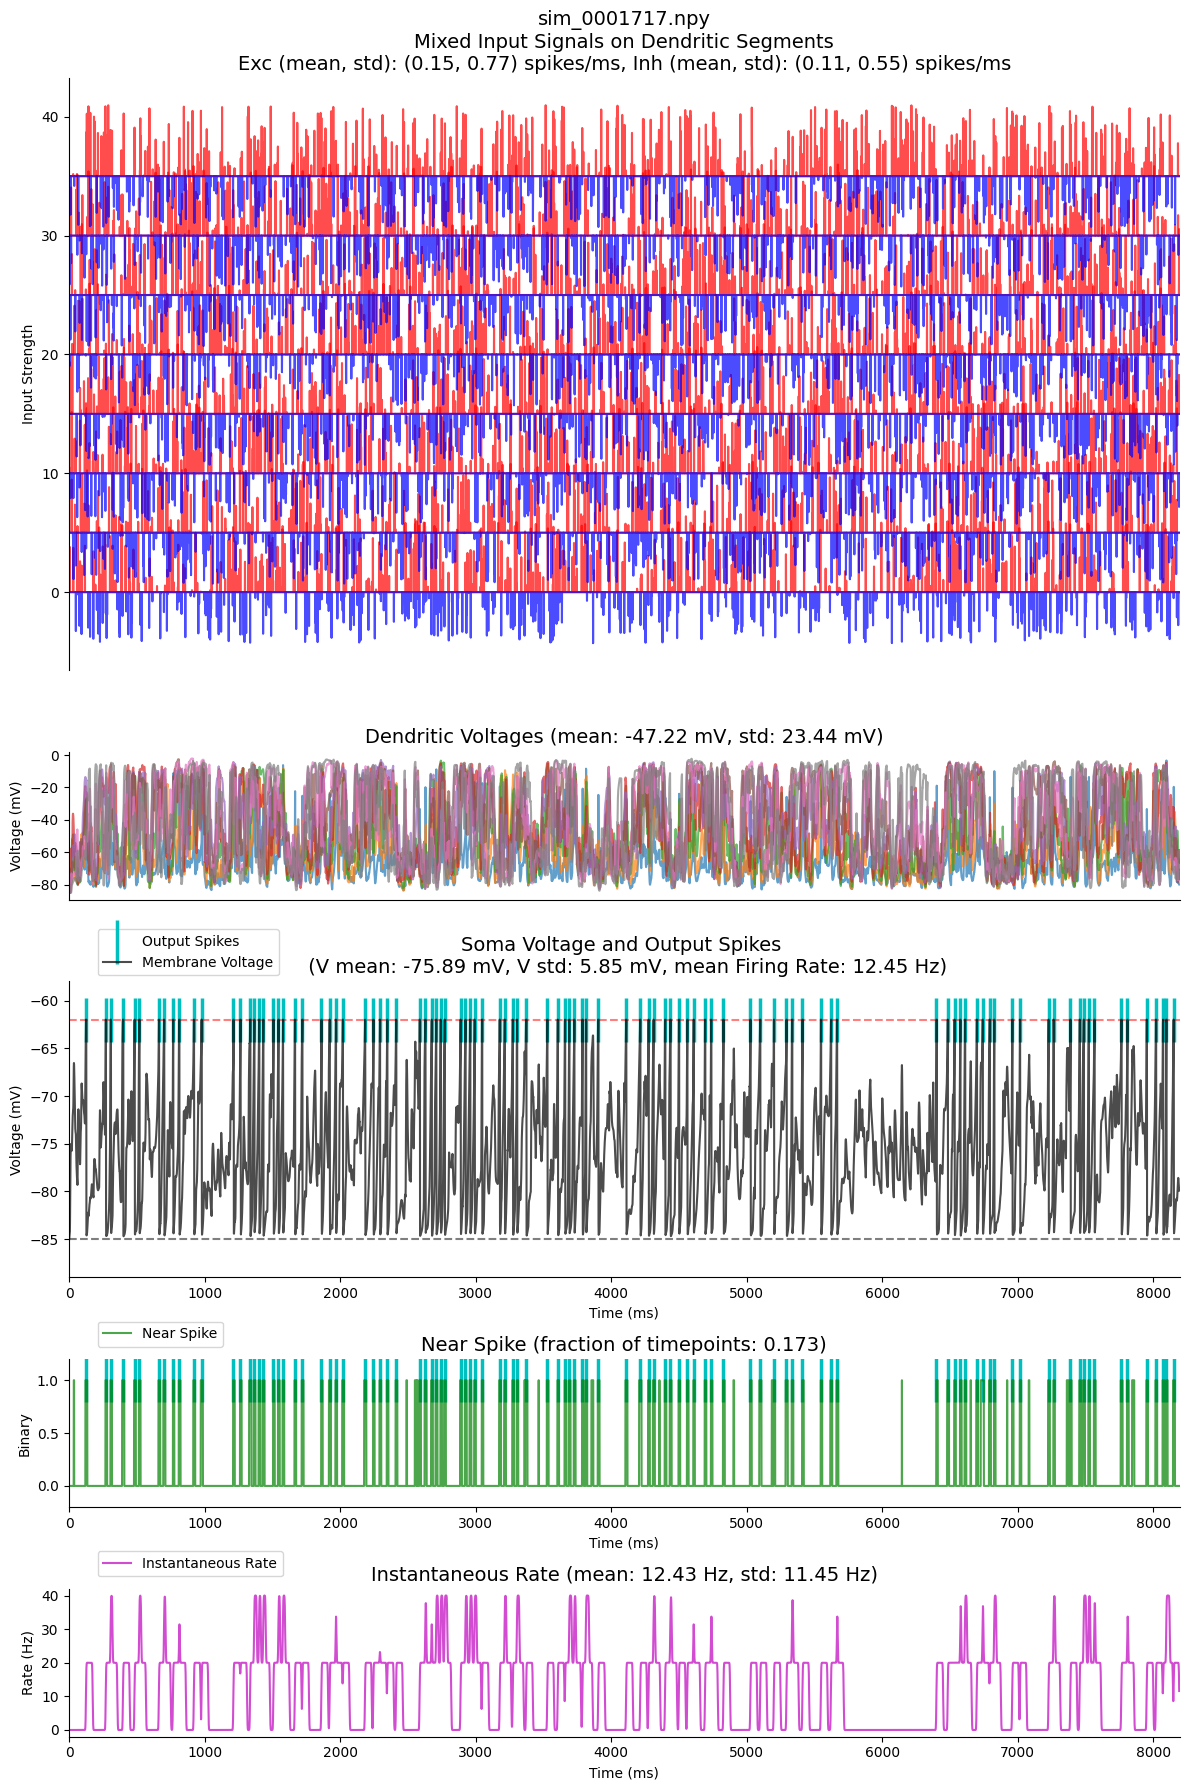

In [7]:
sample_filename = np.random.choice(glob.glob(os.path.join(train_folder, 'output_spikes', '*.npy')))
sample_name = os.path.basename(sample_filename)

# Use the helper function to load and display the sample
fig = load_and_display_sample(sample_name, train_folder, bs_neuron, print_info=True)
plt.show()


## Another sample

----------------------------------------------------------------------
Data folder & sample name:
BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs/train/sim_0003800.npy
----------------------------------------------------------------------
Shapes and dtypes of the data:
----------------------------
X_inputs shape: (8, 8192, 2), dtype: float16
y_spike shape: (8192,), dtype: bool
y_soma shape: (8192,), dtype: float32
y_near_spike shape: (8192,), dtype: bool
y_inst_rate shape: (8192,), dtype: float32
branch_voltage shape: (8, 8192), dtype: float16
----------------------------------------------------------------------
----------------------------------------------------------------------
For current simulation for sim_0003800.npy:
-------------------------------------------
Excitatory input strength (mean, std) = [0.117, 0.776] spikes/ms
Inhibitory input strength (mean, std) = [0.123, 0.888] spikes/ms
Dendritic voltage (mean, std) = [-60.97 mV, 21.12 mV]
Soma voltage (mean, st

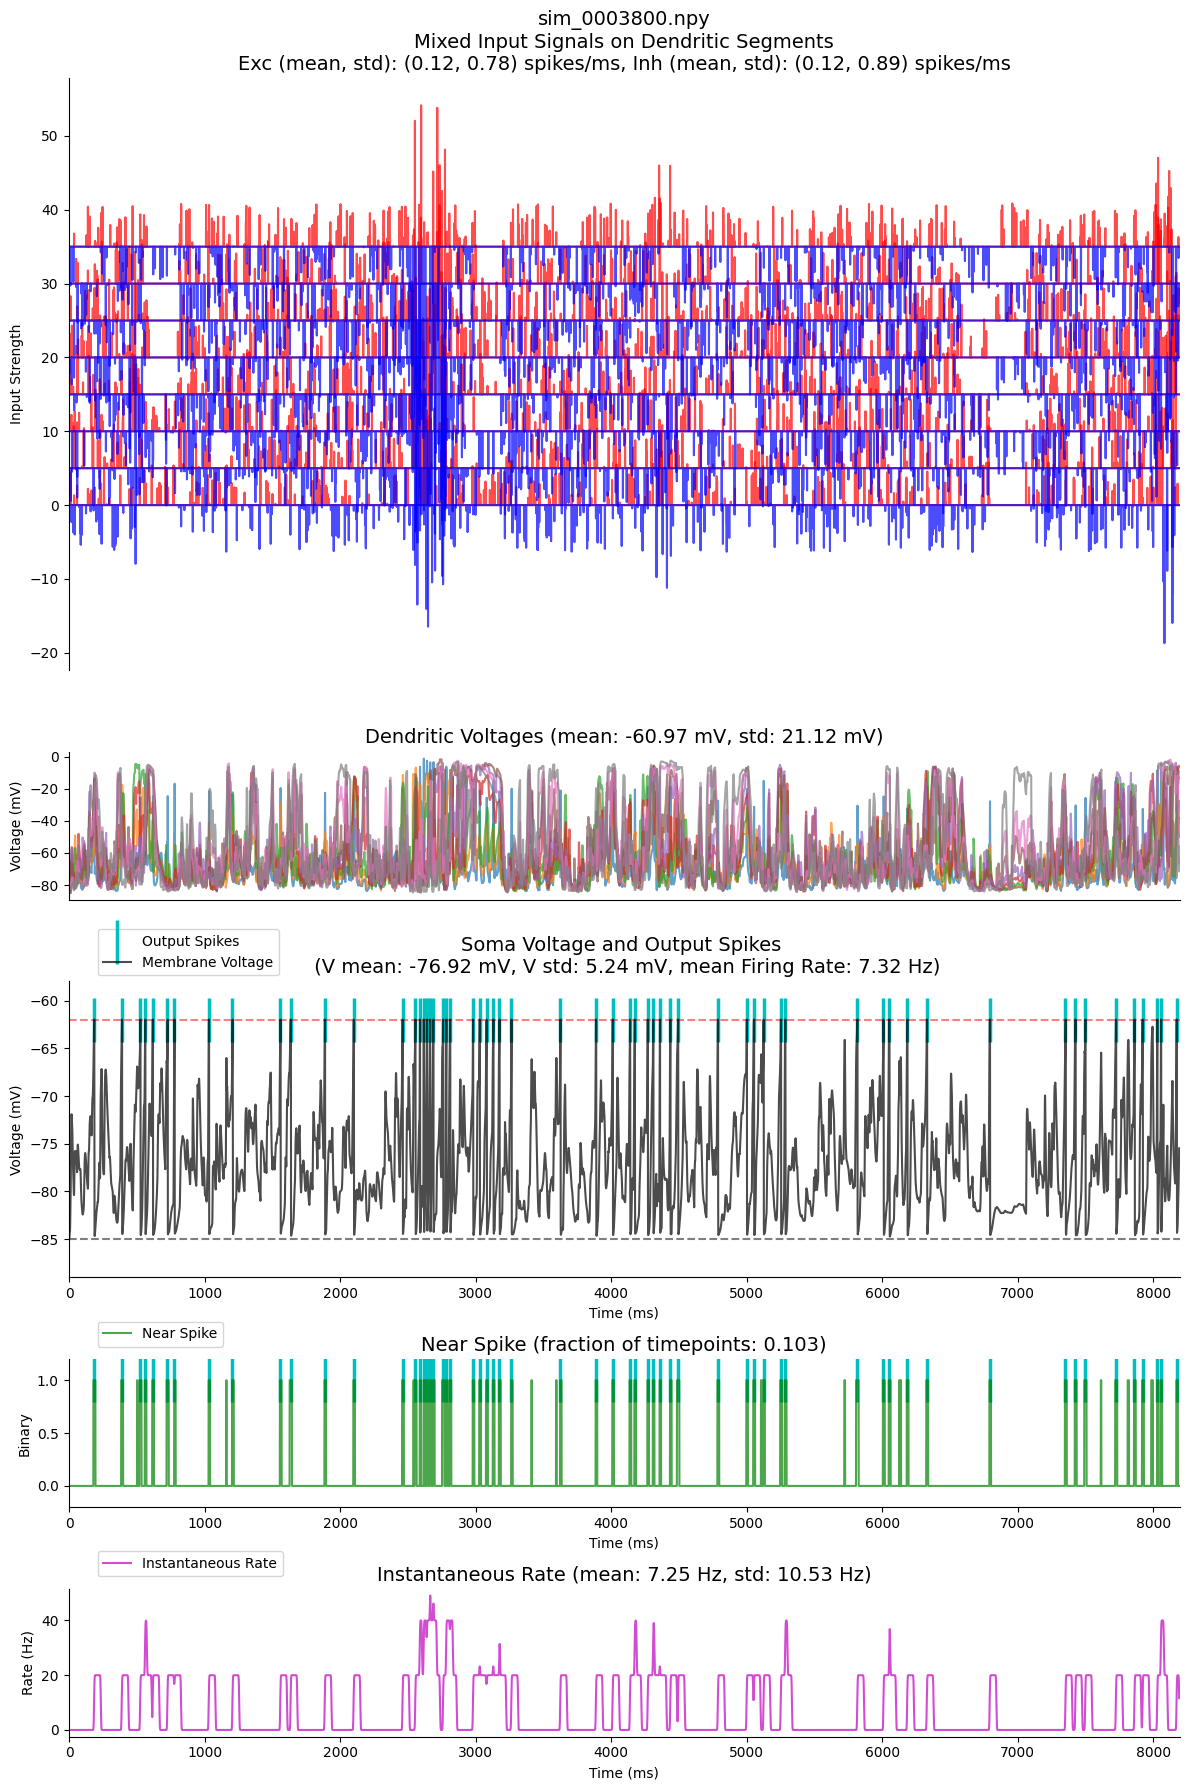

In [8]:
sample_filename = np.random.choice(glob.glob(os.path.join(train_folder, 'output_spikes', '*.npy')))
sample_name = os.path.basename(sample_filename)

# Use the helper function to load and display the sample
fig = load_and_display_sample(sample_name, train_folder, bs_neuron, print_info=True)
plt.show()

## Dataset Statistics (Pre-Filtering)

Collect and visualize statistics across the entire training dataset. This provides insight into the distribution of:
- Firing rates
- Near-spike probabilities  
- Soma voltage statistics (mean and std)
- Instantaneous rate statistics
- Branch voltage statistics

**Expected output**: Histograms showing the distributions of these key metrics across all training samples before filtering.


Processing 7228 files from train...
Processed 5000/7228 samples
Dataset processing time: 0.08 minutes


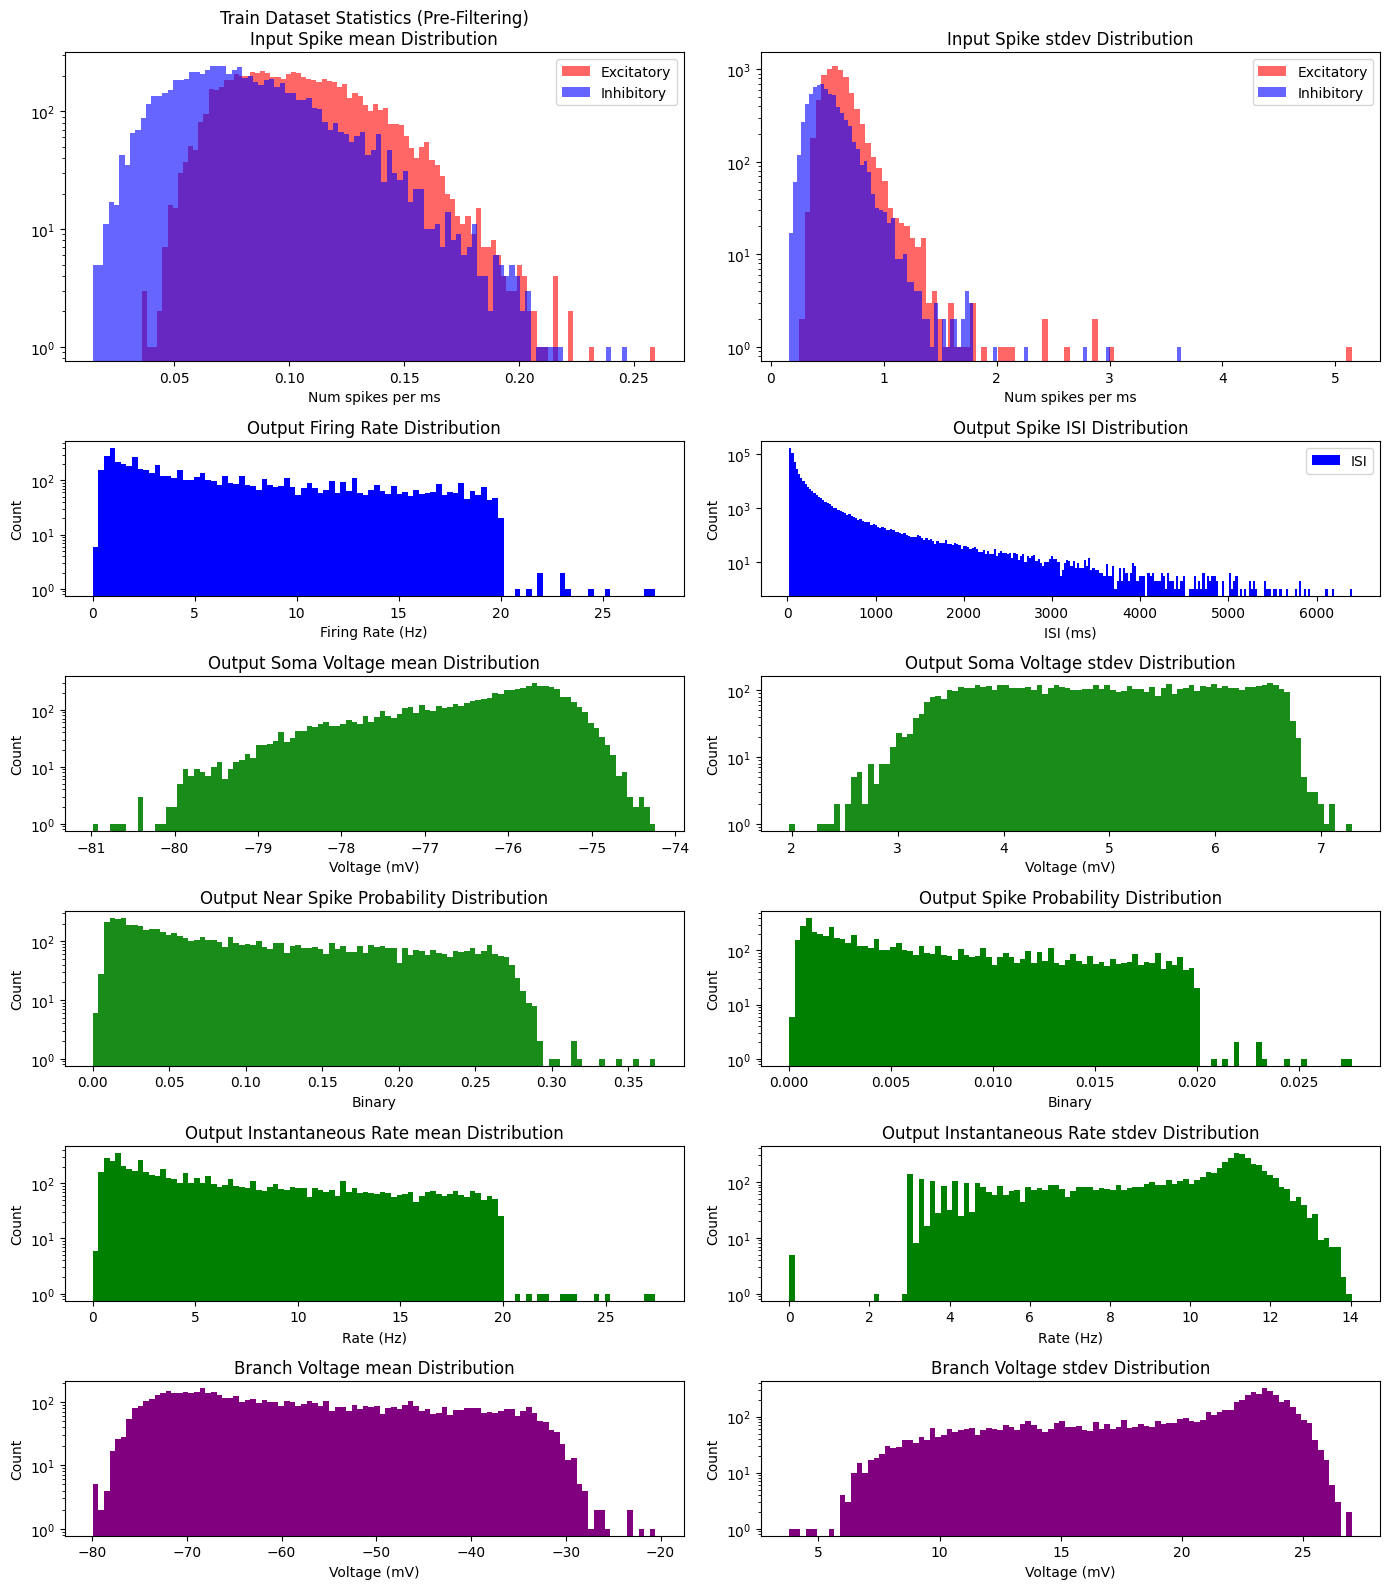

In [9]:
train_stats = collect_dataset_statistics(train_folder)

figure_title_str = "Train Dataset Statistics (Pre-Filtering)"
stats_fig = plot_dataset_statistics(train_stats, figure_title_str)
plt.show()


## Filter Datasets (Optional)

Apply quality filters to remove samples that don't meet our criteria. This step is optional but recommended to ensure high-quality training data.

**Filtering criteria**:
- Firing rate within reasonable range (e.g., 0.4-20 Hz)
- Soma voltage statistics within physiological bounds
- Instantaneous rate variability in acceptable range
- Branch voltages showing proper dendritic activity

Samples that fail criteria are probabilistically removed based on the drop probability settings.

**Expected output**: Summary of how many samples were filtered from each dataset split, along with statistics of the removed samples.


In [10]:
if apply_post_filtering:
    print("Filtering datasets...")
    print("=" * 75)
    
    folders = {
        'Train': train_folder,
        'Valid': valid_folder,
        'Test': test_folder
    }
    
    for name, folder in folders.items():
        print(f"Filtering {name} dataset...")
        stats = filter_dataset_folder(folder, 
                                      firing_rate_hz_range=firing_rate_hz_range, 
                                      avg_near_spike_prob_range=avg_near_spike_prob_range,
                                      soma_v_mV_mean_range=soma_v_mV_mean_range, 
                                      soma_v_mV_std_range=soma_v_mV_std_range, 
                                      inst_rate_hz_mean_range=inst_rate_hz_mean_range,
                                      inst_rate_hz_std_range=inst_rate_hz_std_range,
                                      branch_v_mV_mean_range=branch_v_mV_mean_range,
                                      branch_v_mV_std_range=branch_v_mV_std_range,
                                      drop_prob_for_firing_rate=drop_prob_for_firing_rate,
                                      drop_prob_for_near_spike_prob=drop_prob_for_near_spike_prob,
                                      drop_prob_for_soma_v=drop_prob_for_soma_v,
                                      drop_prob_for_inst_rate=drop_prob_for_inst_rate,
                                      drop_prob_for_branch_v=drop_prob_for_branch_v)
        print('=' * 75)
        print(f"Summary for {name} dataset:")
        print('-' * 28)
        print(f"Files deleted: {stats['num_deleted']}")
        if stats['num_deleted'] > 0:
            print(f"Mean soma voltage of deleted files: {stats['mean_soma_v']:.2f} mV")
            print(f"Mean soma voltage std of deleted files: {stats['std_soma_v']:.2f} mV")
            print(f"Mean firing rate of deleted files: {stats['mean_firing_rate']:.2f} Hz")
            print(f"Mean near spike probability of deleted files: {stats['mean_near_spike_prob']:.2f}")
            print(f"Mean instantaneous rate of deleted files: {stats['mean_inst_rate']:.2f} Hz")
            print(f"Mean branch voltage of deleted files: {stats['mean_branch_v']:.2f} mV")
        print('=' * 75)
        
    print("Filtering complete!")
    
else:
    print("Post-filtering is disabled")


Filtering datasets...
Filtering Train dataset...
Summary for Train dataset:
----------------------------
Files deleted: 17
Mean soma voltage of deleted files: -77.08 mV
Mean soma voltage std of deleted files: 5.37 mV
Mean firing rate of deleted files: 15.30 Hz
Mean near spike probability of deleted files: 0.21
Mean instantaneous rate of deleted files: 15.26 Hz
Mean branch voltage of deleted files: -44.33 mV
Filtering Valid dataset...
Summary for Valid dataset:
----------------------------
Files deleted: 2
Mean soma voltage of deleted files: -75.43 mV
Mean soma voltage std of deleted files: 6.86 mV
Mean firing rate of deleted files: 20.51 Hz
Mean near spike probability of deleted files: 0.29
Mean instantaneous rate of deleted files: 20.44 Hz
Mean branch voltage of deleted files: -28.09 mV
Filtering Test dataset...
Summary for Test dataset:
----------------------------
Files deleted: 1
Mean soma voltage of deleted files: -77.28 mV
Mean soma voltage std of deleted files: 3.00 mV
Mean firi

## Dataset Statistics (Post-Filtering)

After filtering, we re-collect statistics to verify that the remaining samples meet our quality criteria. The distributions should now be tighter and within the acceptable ranges we defined.

**Expected output**: Updated histograms showing cleaner distributions compared to pre-filtering statistics. Outliers and pathological samples should be removed.


Processing 7211 files from train...
Processed 5000/7211 samples
Dataset processing time: 0.09 minutes


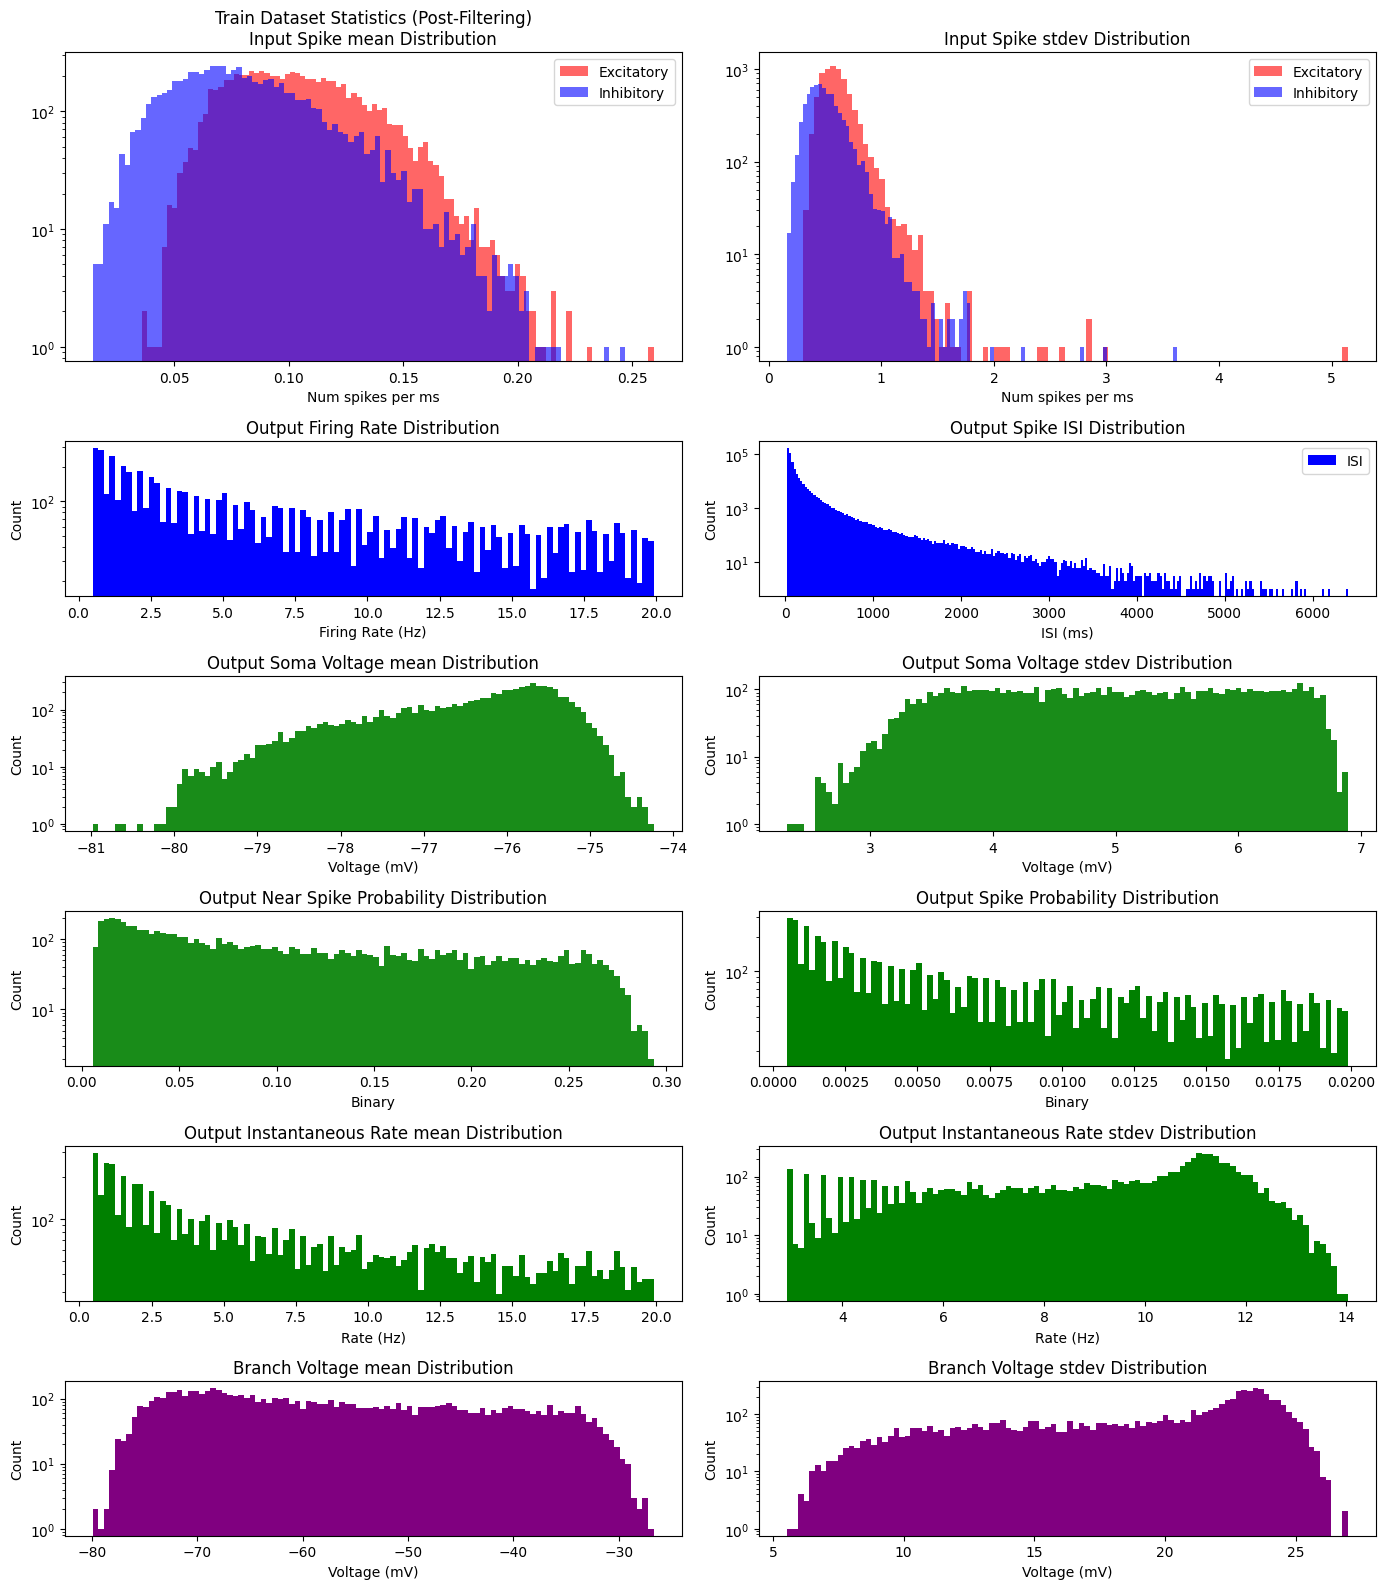

In [11]:
if apply_post_filtering:
    # Collect statistics of the entire train dataset post-filtering and plot it
    train_stats = collect_dataset_statistics(train_folder)
    
    figure_title_str = "Train Dataset Statistics (Post-Filtering)"
    stats_fig = plot_dataset_statistics(train_stats, figure_title_str)
    plt.show()
else:
    print("Skipping post-filtering statistics (filtering was disabled)")


## Summary

The dataset has been successfully generated! 

### What we created:
- **Training set**: Multiple simulations with varied input patterns for model training
- **Validation set**: Held-out data for hyperparameter tuning and monitoring overfitting
- **Test set**: Final evaluation data to assess model generalization

### Dataset structure:
Each simulation includes:
- **Inputs**: Excitatory and inhibitory synaptic inputs on dendritic segments
- **Outputs**: 
  - Soma voltage trace
  - Binary spike times
  - Near-spike signal (for auxiliary training)
  - Instantaneous firing rate (smoothed)
  - Intermediate dendritic voltages

### Next steps:
1. Use the training data to fit a neural network model (see `train_DNN_twin_of_BS_neuron.py`)
2. Validate model performance on the validation set
3. Evaluate final model quality on the test set
4. Optionally, generate additional data with different parameter ranges to expand the dataset


In [12]:
# Display final dataset sizes
train_samples = len(glob.glob(os.path.join(train_folder, 'output_spikes', '*.npy')))
valid_samples = len(glob.glob(os.path.join(valid_folder, 'output_spikes', '*.npy')))
test_samples = len(glob.glob(os.path.join(test_folder, 'output_spikes', '*.npy')))

print("=" * 75)
print("Final Dataset Summary")
print("=" * 75)
print(f"Dataset location: {dataset_folder}")
print(f"Neuron model: {bs_neuron.short_name}")
print()
print(f"Training samples:   {train_samples:4d}")
print(f"Validation samples: {valid_samples:4d}")
print(f"Test samples:       {test_samples:4d}")
print(f"Total samples:      {train_samples + valid_samples + test_samples:4d}")
print("=" * 75)


Final Dataset Summary
Dataset location: /home/davidbeniaguev/Desktop/Data/BS_neuron_data/BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs
Neuron model: BallAndStickNeuron_Soma_Hay2011_Dend_Lxd_2048um_x_1_0um_8segs

Training samples:   7211
Validation samples:  588
Test samples:        605
Total samples:      8404
